In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import string

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(device)

cuda:0


In [4]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i=torch.range(1,n_dest)[:,None]
    j=torch.range(1,n_src)
    m = i >= j - n_src + n_dest
    mask=m.bool()
    return ~mask
#     mask=torch.reshape(mask, [1, n_dest, n_src])
#     mult=[batch_size,1,1]
#     return torch.tile(mask,mult);

In [43]:
# causal_attention_mask(2,5,5,torch.bool)

In [5]:
def padding_mask(input):
    # Create mask which marks the zero padding values in the input by a 1
#     print(input)
#     input=torch.tensor(input['train']['input_ids'])
    mask=torch.eq(input, torch.zeros_like(input))

 
    return mask

In [8]:
# padding_mask(torch.tensor([[1,2,3,0,0,0],[2,0,0,0,0,0]]))

tensor([[False, False, False,  True,  True,  True],
        [False,  True,  True,  True,  True,  True]])

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads,batch_first,rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim,num_heads,batch_first=batch_first)

    def forward(self, inputs,pad_mask):
        input_shape = inputs.size()
        batch_size = input_shape[0]
        seq_len = input_shape[1]
#         pad_mask=padding_mask(inputs)
        pad_mask.to(device)
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, torch.bool).to(device)
        attention_output,a = self.attention(inputs, inputs,inputs, key_padding_mask=pad_mask, attn_mask=causal_mask,need_weights=True,average_attn_weights=False)
        return attention_output,a

In [7]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim,max_norm=1)
        self.pos_emb = nn.Embedding(maxlen,embed_dim)

    def forward(self, x):
        maxlen = x.size()[-1]
        pad_mask=padding_mask(x)
        positions = torch.range(start=0, end=maxlen-1, step=1,dtype=torch.int32).to(device)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return (x + positions),pad_mask

In [107]:
vocab_size =50257 #28996  # Only consider the top 20k words
# maxlen = 20  # Max sequence size
# embed_dim = 256  # Embedding size for each token
# num_heads = 8  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer
class Model(nn.Module):
    def __init__(self,num_heads,embed_dim,maxlen):
        super(Model, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim,True)
        self.transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim,True)
        self.MLP1=nn.LazyLinear(feed_forward_dim)
        self.MLP2=nn.LazyLinear(feed_forward_dim)
        self.outputs= nn.LazyLinear(vocab_size)
        
    def forward(self, x):
        x,pad_mask = self.embedding_layer(x)
#         print(x,"maximum=",torch.max(x))
        x,att = self.transformer_block(x,pad_mask)
        x=self.MLP1(x)
        x,a = self.transformer_block2(x,pad_mask)
#         print(x)
        x=self.MLP2(x);
        x = self.outputs(x)
        
        return x,a


In [40]:
import wandb

In [53]:
#CREATING THE SWEEP CONFIG
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    "Heads": {
        'values': [8]
        },
    "Embedding": {
        'values': [256]
        },
    "MaxLen": {
        'values': [20]
        }
    }

sweep_config['parameters'] = parameters_dict

In [54]:
wandb.login(key="4559ac73746fbfa187390725b41dbd1df725b9fd")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [55]:
sweep_id = wandb.sweep(sweep_config,project="transformer", entity="as278")

Create sweep with ID: lbtnm705
Sweep URL: https://wandb.ai/as278/transformer/sweeps/lbtnm705


In [44]:
import pandas as pd
import os
import re
directories = [
    "/kaggle/input/aclimdb-v1/aclImdb/train/pos",
    "/kaggle/input/aclimdb-v1/aclImdb/train/neg",
    "/kaggle/input/aclimdb-v1/aclImdb/test/pos",
    "/kaggle/input/aclimdb-v1/aclImdb/test/neg",
]

from datasets import load_dataset
filenames = []
testfiles=[]
testcount=0
for dir in directories:
    if dir=="/kaggle/input/aclimdb-v1/aclImdb/test/neg":
        for f in os.listdir(dir):
            if testcount<100:
                testfiles.append(os.path.join(dir, f))
                testcount+=1
            else:
                filenames.append(os.path.join(dir, f))
    else:
        for f in os.listdir(dir):
            filenames.append(os.path.join(dir, f))

DATASET = load_dataset("text", data_files=filenames)
TESTDATASET=load_dataset("text", data_files=testfiles)
def processing(s):
  s['text']=s['text'].lower()
  s['text']=re.sub("<br />", " ", s['text'])
  s['text']=re.sub(f"([{string.punctuation}])", r" \1", s['text'])
  return s

DATASET=DATASET.map(processing)
TESTDATASET=TESTDATASET.map(processing)


Resolving data files:   0%|          | 0/49900 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/49900 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

In [9]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [10]:
# dataset

In [16]:
# model=Model()
# # model.load_state_dict(torch.load("/kaggle/input/weights2/transformer_weights.pth")) 
# model.to(device)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model(
  (embedding_layer): TokenAndPositionEmbedding(
    (token_emb): Embedding(50257, 256, max_norm=1)
    (pos_emb): Embedding(20, 256)
  )
  (transformer_block): TransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
  )
  (outputs): LazyLinear(in_features=0, out_features=50257, bias=True)
)

<!-- # model= Model()
# model.to(device) -->

In [109]:
class TextGenerator(nn.Module):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, maxlen,top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
#         self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
        self.maxlen=maxlen
#         self.model=model

    def sample_from(self, logits):
        logits, indices = torch.topk(logits, k=self.k, sorted=True)
        logits=logits.cpu()
        indices=indices.cpu()
        indices = np.asarray(indices).astype("int32")
       
        softmax=nn.Softmax(dim=0)
        preds = softmax(logits)
        preds = np.asarray(preds).astype("float32")
#         return np.random.choice(indices, p=preds) THIS IS THE CORRECT CODE, BUT HAD TO COMMENT IT AS
#.        PROBABILITIES HAVE NAN AND I HAD TO VERIFY PIPELINE, BELOW LINE WILL BE REMOVED ONCE NAN ISSUE 
#.        IS RESOLVED
        return np.random.choice(indices, p=preds)
#         return np.random.choice(5, 1, p=[0.1, 0, 0.3, 0.6, 0])

    def detokenize(self, number):
        return tokenizer.decode(number)

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        attention_scores=[]
        ret_txt=[]
        while num_tokens_generated <= self.max_tokens:
            pad_len = self.maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                data = start_tokens[:self.maxlen]
                sample_index = self.maxlen - 1
            elif pad_len > 0:
                data = start_tokens + [0] * pad_len
            else:
                data = start_tokens
                
            data = torch.Tensor(np.array([data])).type(torch.int32).to(device)
            
            y,attention_scores = model(data)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        ret_txt=[self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        print(f"generated text:\n{txt}\n")
        return attention_scores[0],ret_txt

# Tokenize starting prompt
# word_to_index = {}
# for index, word in enumerate(vocab):
#     word_to_index[word] = index

start_prompt = "this movie is"
start_tokens=tokenizer(start_prompt)['input_ids']
# start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
# text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [49]:
from datasets import Dataset


In [65]:
# model=Model(8,256,20)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [66]:
# torch.save(model.state_dict(),f"/kaggle/working/saved_models/transformer_weights_MLPlayers.pth")


In [84]:
# import os
# # os.chdir("saved_models")
# !pwd
# !zip -r file.zip /kaggle/working/saved_models

/kaggle/working/saved_models
updating: kaggle/working/saved_models/ (stored 0%)
updating: kaggle/working/saved_models/transformer_weights_MLPlayers.pth (deflated 8%)
updating: kaggle/working/saved_models/transformer_weights_2layers.pth (deflated 7%)


In [85]:
# from IPython.display import FileLink
# FileLink(r'file.zip')

/kaggle/working/saved_models/file.zip

In [69]:
# !ls

__notebook_source__.ipynb  saved_models  wandb


In [16]:
!mkdir /kaggle/working/saved_models/

In [56]:
def training(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
#         run.name = "Heads-"+str(config.Heads)+"Embedding-"+str(config.Embedding)+"MaxLen-"+str(config.MaxLen)
        run.name="2 layers"
        def padding(s):
            maxlen=config.MaxLen
            if len(s['input_ids'])<maxlen :
                s['input_ids']=s['input_ids']+[0]*(maxlen-len(s['input_ids']))
            return s
               
        model=Model(config.Heads,config.Embedding,config.MaxLen)
        # model.load_state_dict(torch.load("/kaggle/input/weights2/transformer_weights.pth")) 
        model.to(device)
        
        dataset = DATASET.map(lambda dataset: tokenizer(dataset["text"],truncation=True, max_length=config.MaxLen))
        testdataset = TESTDATASET.map(lambda dataset: tokenizer(dataset["text"],truncation=True, max_length=config.MaxLen))
        
        dataset=dataset.map(padding)
        testdataset=testdataset.map(padding)
        
        train_dataset= Dataset.from_dict({"id": dataset['train']['input_ids']})
        train_dataset = train_dataset.with_format("torch")
        
        testdataset= Dataset.from_dict({"id": testdataset['train']['input_ids']})
        testdataset = testdataset.with_format("torch")
        
        count=0
        TRAIN=[]
        train_loader=DataLoader(train_dataset,batch_size=50,shuffle=True)
        test_loader=DataLoader(testdataset,batch_size=100,shuffle=True)
       
        for i in train_loader:
            TRAIN.append(random.choice(i['id']))
            if count>100:
                break
            count+=1
        
        TRAIN=torch.stack(TRAIN,0) 
        optim=torch.optim.AdamW(model.parameters(),lr=1e-3)
        loss_fn=torch.nn.CrossEntropyLoss()
        loss_stats = {
            'train_loss': [],
            'test_loss': [],
            'train_acc': [],
            'test_acc': []
        }
        print("7")
        for epoch in tqdm(range(20)):
            for batch in tqdm(train_loader):
                optim.zero_grad()
        #         print(batch['id'][:,:-1])
                input_ids=batch['id'][:,:-1].to(device)
        #         print(input_ids.shape())
                labels=batch['id'][:,1:].to(device)
                outputs,att=model.forward(input_ids)
                labels=nn.functional.one_hot(labels,num_classes=vocab_size).type(torch.float)
                loss=loss_fn(outputs,labels)
                loss.backward()
                optim.step()

            with torch.no_grad():
        #         TextGenerator(40, start_tokens).on_epoch_end(epoch);
                train_input=TRAIN[:,:-1].to(device)
                train_output=TRAIN[:,1:].to(device)
                train_outputs,att=model.forward(train_input)
                labels=nn.functional.one_hot(train_output,num_classes=vocab_size).type(torch.float)
                train_loss=loss_fn(train_outputs,labels).cpu().item()
                loss_stats['train_loss'].append(train_loss)

                train_pred_softmax = torch.log_softmax(train_outputs, dim = 2)
                _, train_pred_tags = torch.max(train_pred_softmax, dim = 2)    
                train_correct_pred = (train_pred_tags == train_output).float()
                size=train_correct_pred.shape[0]*train_correct_pred.shape[1]
                train_acc = train_correct_pred.sum() / size
                train_acc = train_acc * 100
                train_acc=train_acc.cpu()
                loss_stats['train_acc'].append(train_acc.cpu())

                for b in tqdm(test_loader):
                    test_input=b['id'][:,:-1].to(device)
            #         print(input_ids.shape())
                    test_output=b['id'][:,1:].to(device)
                    test_outputs,att=model.forward(test_input)
                    labels=nn.functional.one_hot(test_output,num_classes=vocab_size).type(torch.float)
                    test_loss=loss_fn(test_outputs,labels).cpu().item()
                    test_pred_softmax = torch.log_softmax(test_outputs, dim = 2)
                    _, test_pred_tags = torch.max(test_pred_softmax, dim = 2)    
                    test_correct_pred = (test_pred_tags == test_output).float()
                    size=test_correct_pred.shape[0]*test_correct_pred.shape[1]
                    test_acc = test_correct_pred.sum() / size
                    test_acc = test_acc * 100
                    test_acc=test_acc.cpu()
                    loss_stats['test_acc'].append(test_acc.cpu())
                    loss_stats['test_loss'].append(test_loss)
                    
                wandb.log({"Train Loss":train_loss, "Test Loss":test_loss,"Train Accuracy":train_acc,"Test Accuracy":test_acc}, step=epoch)
#         TextGenerator(5, start_tokens,config.MaxLen,model).on_epoch_end(epoch);
        torch.save(model.state_dict(),f"/kaggle/working/saved_models/transformer_weights_MLPlayers.pth")

        
        

In [ ]:
wandb.agent(sweep_id, training)

In [76]:
# with torch.no_grad():
# #     TextGenerator(40, start_tokens).on_epoch_end(epoch);
#     train_input=TEST[:,:-1].to(device)
#     train_output=TEST[:,1:].to(device)
#     outputs,att=model.forward(train_input)
#     labels=nn.functional.one_hot(train_output,num_classes=vocab_size).type(torch.float)
#     loss=loss_fn(outputs,labels).cpu().item()
#     y_pred_softmax = torch.log_softmax(outputs, dim = 2)
#     _, y_pred_tags = torch.max(y_pred_softmax, dim = 2)    
#     correct_pred = (y_pred_tags == train_output).float()
#     acc = correct_pred.sum() / len(correct_pred)

#     acc = torch.round(acc * 100)
#     print(acc)
#     print(loss)

# for b in tqdm(test_loader):
#     test_input=b['id'][:,:-1].to(device)
# #         print(input_ids.shape())
#     test_output=b['id'][:,1:].to(device)
#     outputs,att=model.forward(test_input)

#     labels=nn.functional.one_hot(test_output,num_classes=vocab_size).type(torch.float)
#     temp_loss=loss_fn(outputs,labels).cpu().item()
#     y_pred_softmax = torch.log_softmax(outputs, dim = 2)
#     _, y_pred_tags = torch.max(y_pred_softmax, dim = 2) 
#     correct_pred = (y_pred_tags == test_output).float()
#     size=correct_pred.shape[0]*correct_pred.shape[1]
#     acc = correct_pred.sum() / size
#     acc = torch.round(acc * 100)
#     loss_stats['test_acc'].append(acc.cpu())
#     loss_stats['test_loss'].append(temp_loss)
#     break;

  0%|          | 0/125 [00:00<?, ?it/s]

tensor(0., device='cuda:0')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


In [ ]:
# train_loss_df = pd.DataFrame(loss_stats['train_loss']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# # Plot the dataframes
# fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))
# sns.lineplot(data=train_loss_df, x = "epochs", y="value", hue="variable",  ax=axes).set_title('Train Loss')


# test_loss_df = pd.DataFrame.from_dict(loss_stats['test_loss']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# # Plot the dataframes
# fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))
# sns.lineplot(data=test_loss_df, x = "epochs", y="value", hue="variable",  ax=axes).set_title('Test Loss')

# train_acc_df = pd.DataFrame(loss_stats['train_acc']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# # Plot the dataframes
# fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))
# sns.lineplot(data=train_acc_df, x = "epochs", y="value", hue="variable",  ax=axes).set_title('Train Acc')


# test_acc_df = pd.DataFrame.from_dict(loss_stats['test_acc']).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
# fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))
# sns.lineplot(data=test_acc_df, x = "epochs", y="value", hue="variable",  ax=axes).set_title('Test Acc')



In [ ]:
# print(loss_stats['test'],loss_stats['train'])

In [ ]:
# !mkdir /kaggle/working/saved_models/
# torch.save(model.state_dict(),"/kaggle/working/saved_models/transformer_weights_losses.pth")

In [108]:
model=Model(8,128,20)
model.load_state_dict(torch.load("/kaggle/input/best-mlp-layer/transformer_weights_MLPlayers.pth")) 
model.to(device)

Model(
  (embedding_layer): TokenAndPositionEmbedding(
    (token_emb): Embedding(50257, 128, max_norm=1)
    (pos_emb): Embedding(20, 128)
  )
  (transformer_block): TransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (transformer_block2): TransformerBlock(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP1): LazyLinear(in_features=0, out_features=128, bias=True)
  (MLP2): LazyLinear(in_features=0, out_features=128, bias=True)
  (outputs): LazyLinear(in_features=0, out_features=50257, bias=True)
)

In [130]:
with torch.no_grad():
    score,keys=TextGenerator(7, start_tokens,20).on_epoch_end(1);
score=score.cpu().numpy()

generated text:
this  movie  is  been  bitten  been  bitten  been  necessarily  necessarily iver



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


In [112]:
maxlen=20

In [37]:
score[0][0:10,0:10].shape

(10, 10)

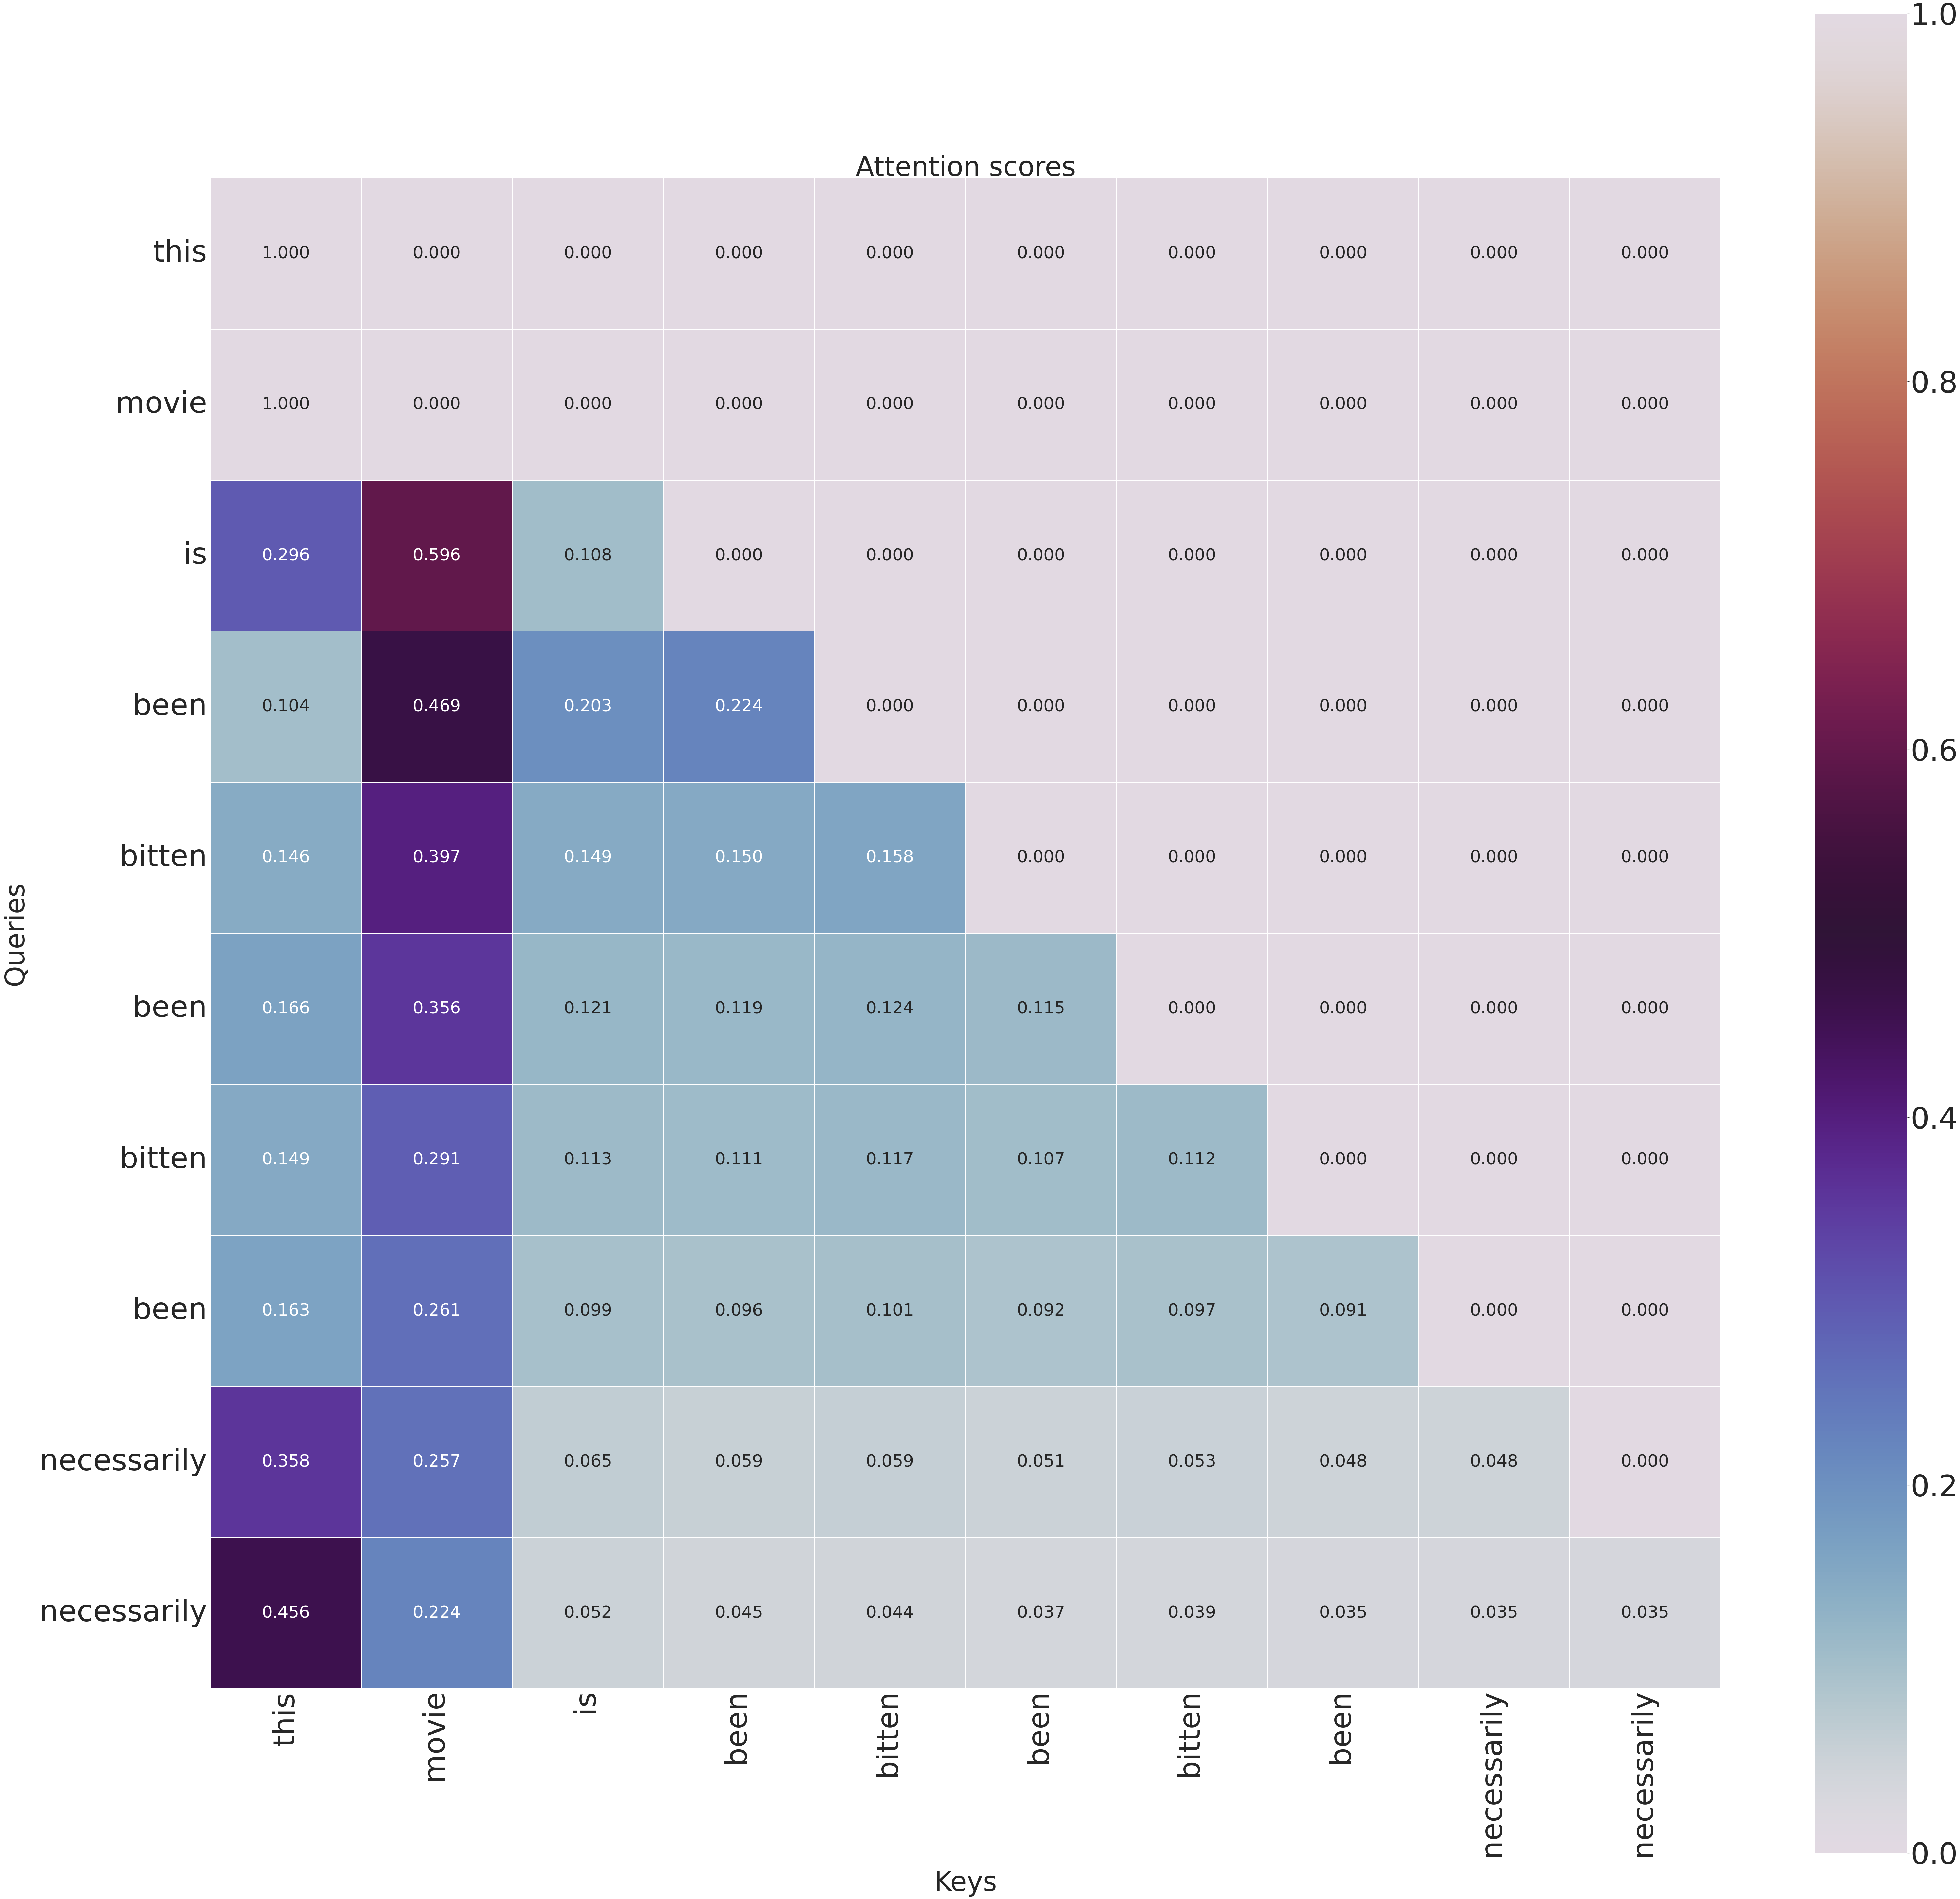

In [131]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[0][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
# plt.savefig('2Layer_Head1.jpg')

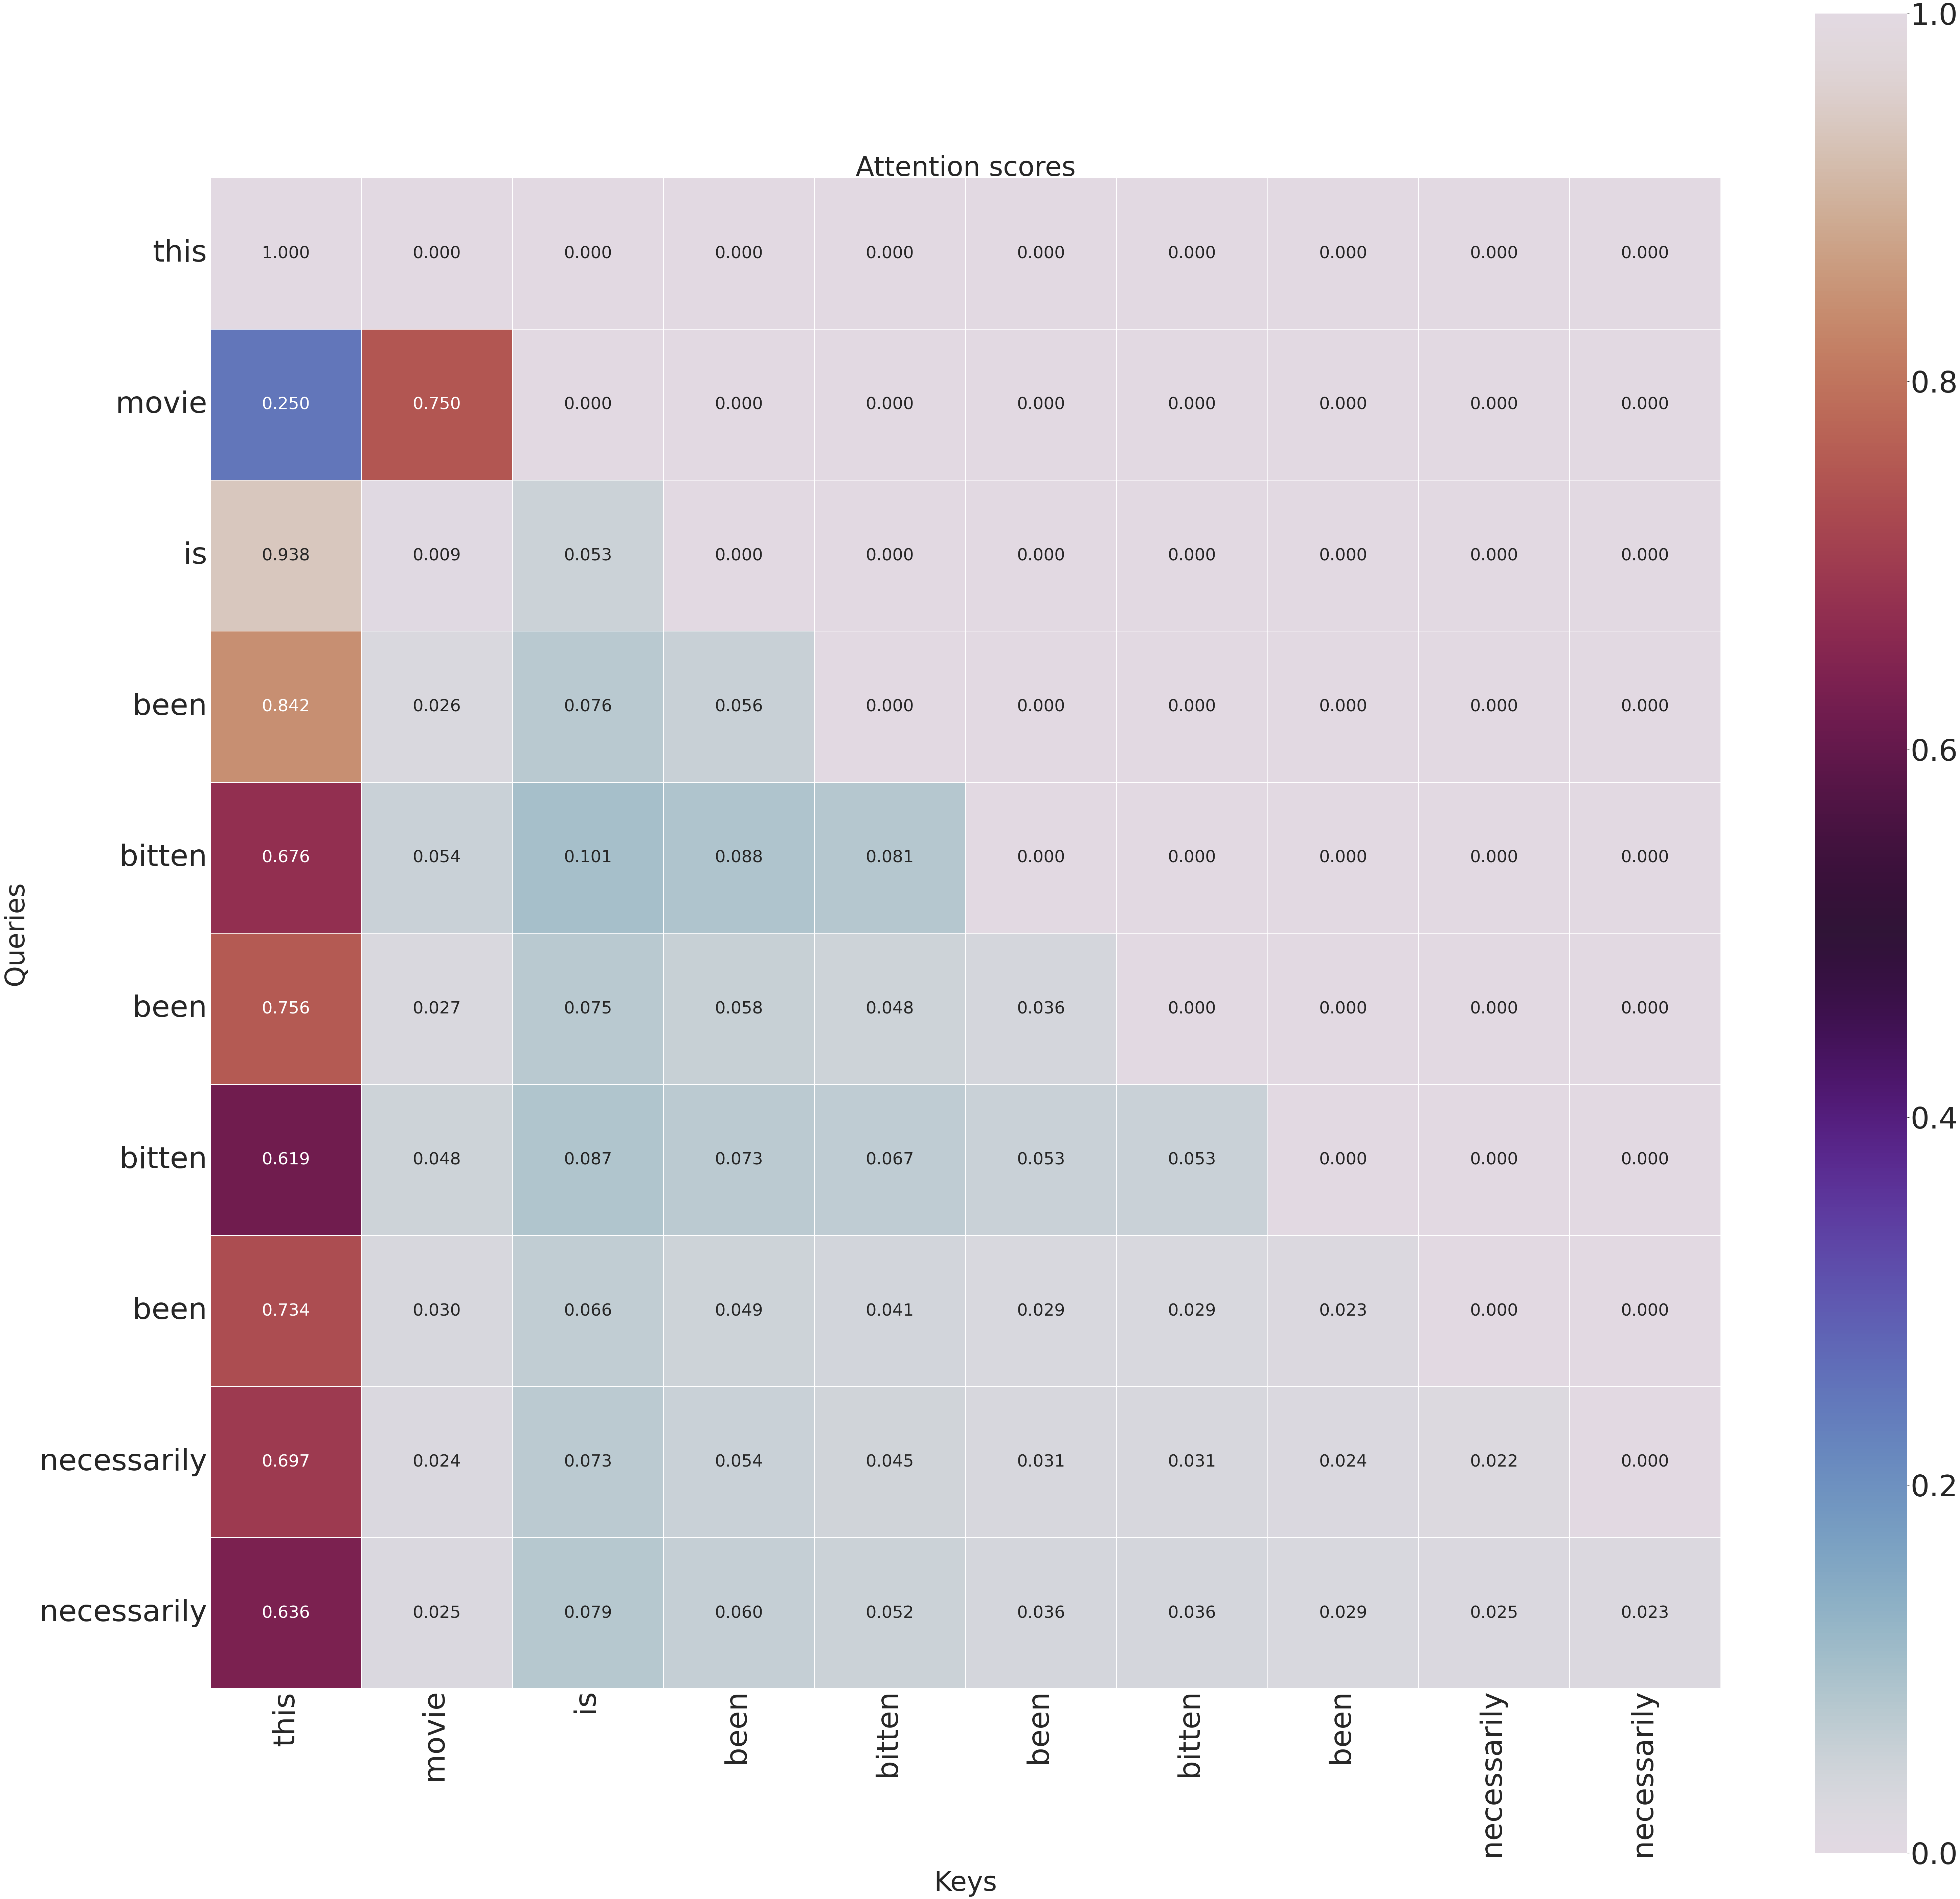

In [132]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[1][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
plt.savefig('2Layer_Head2.jpg')

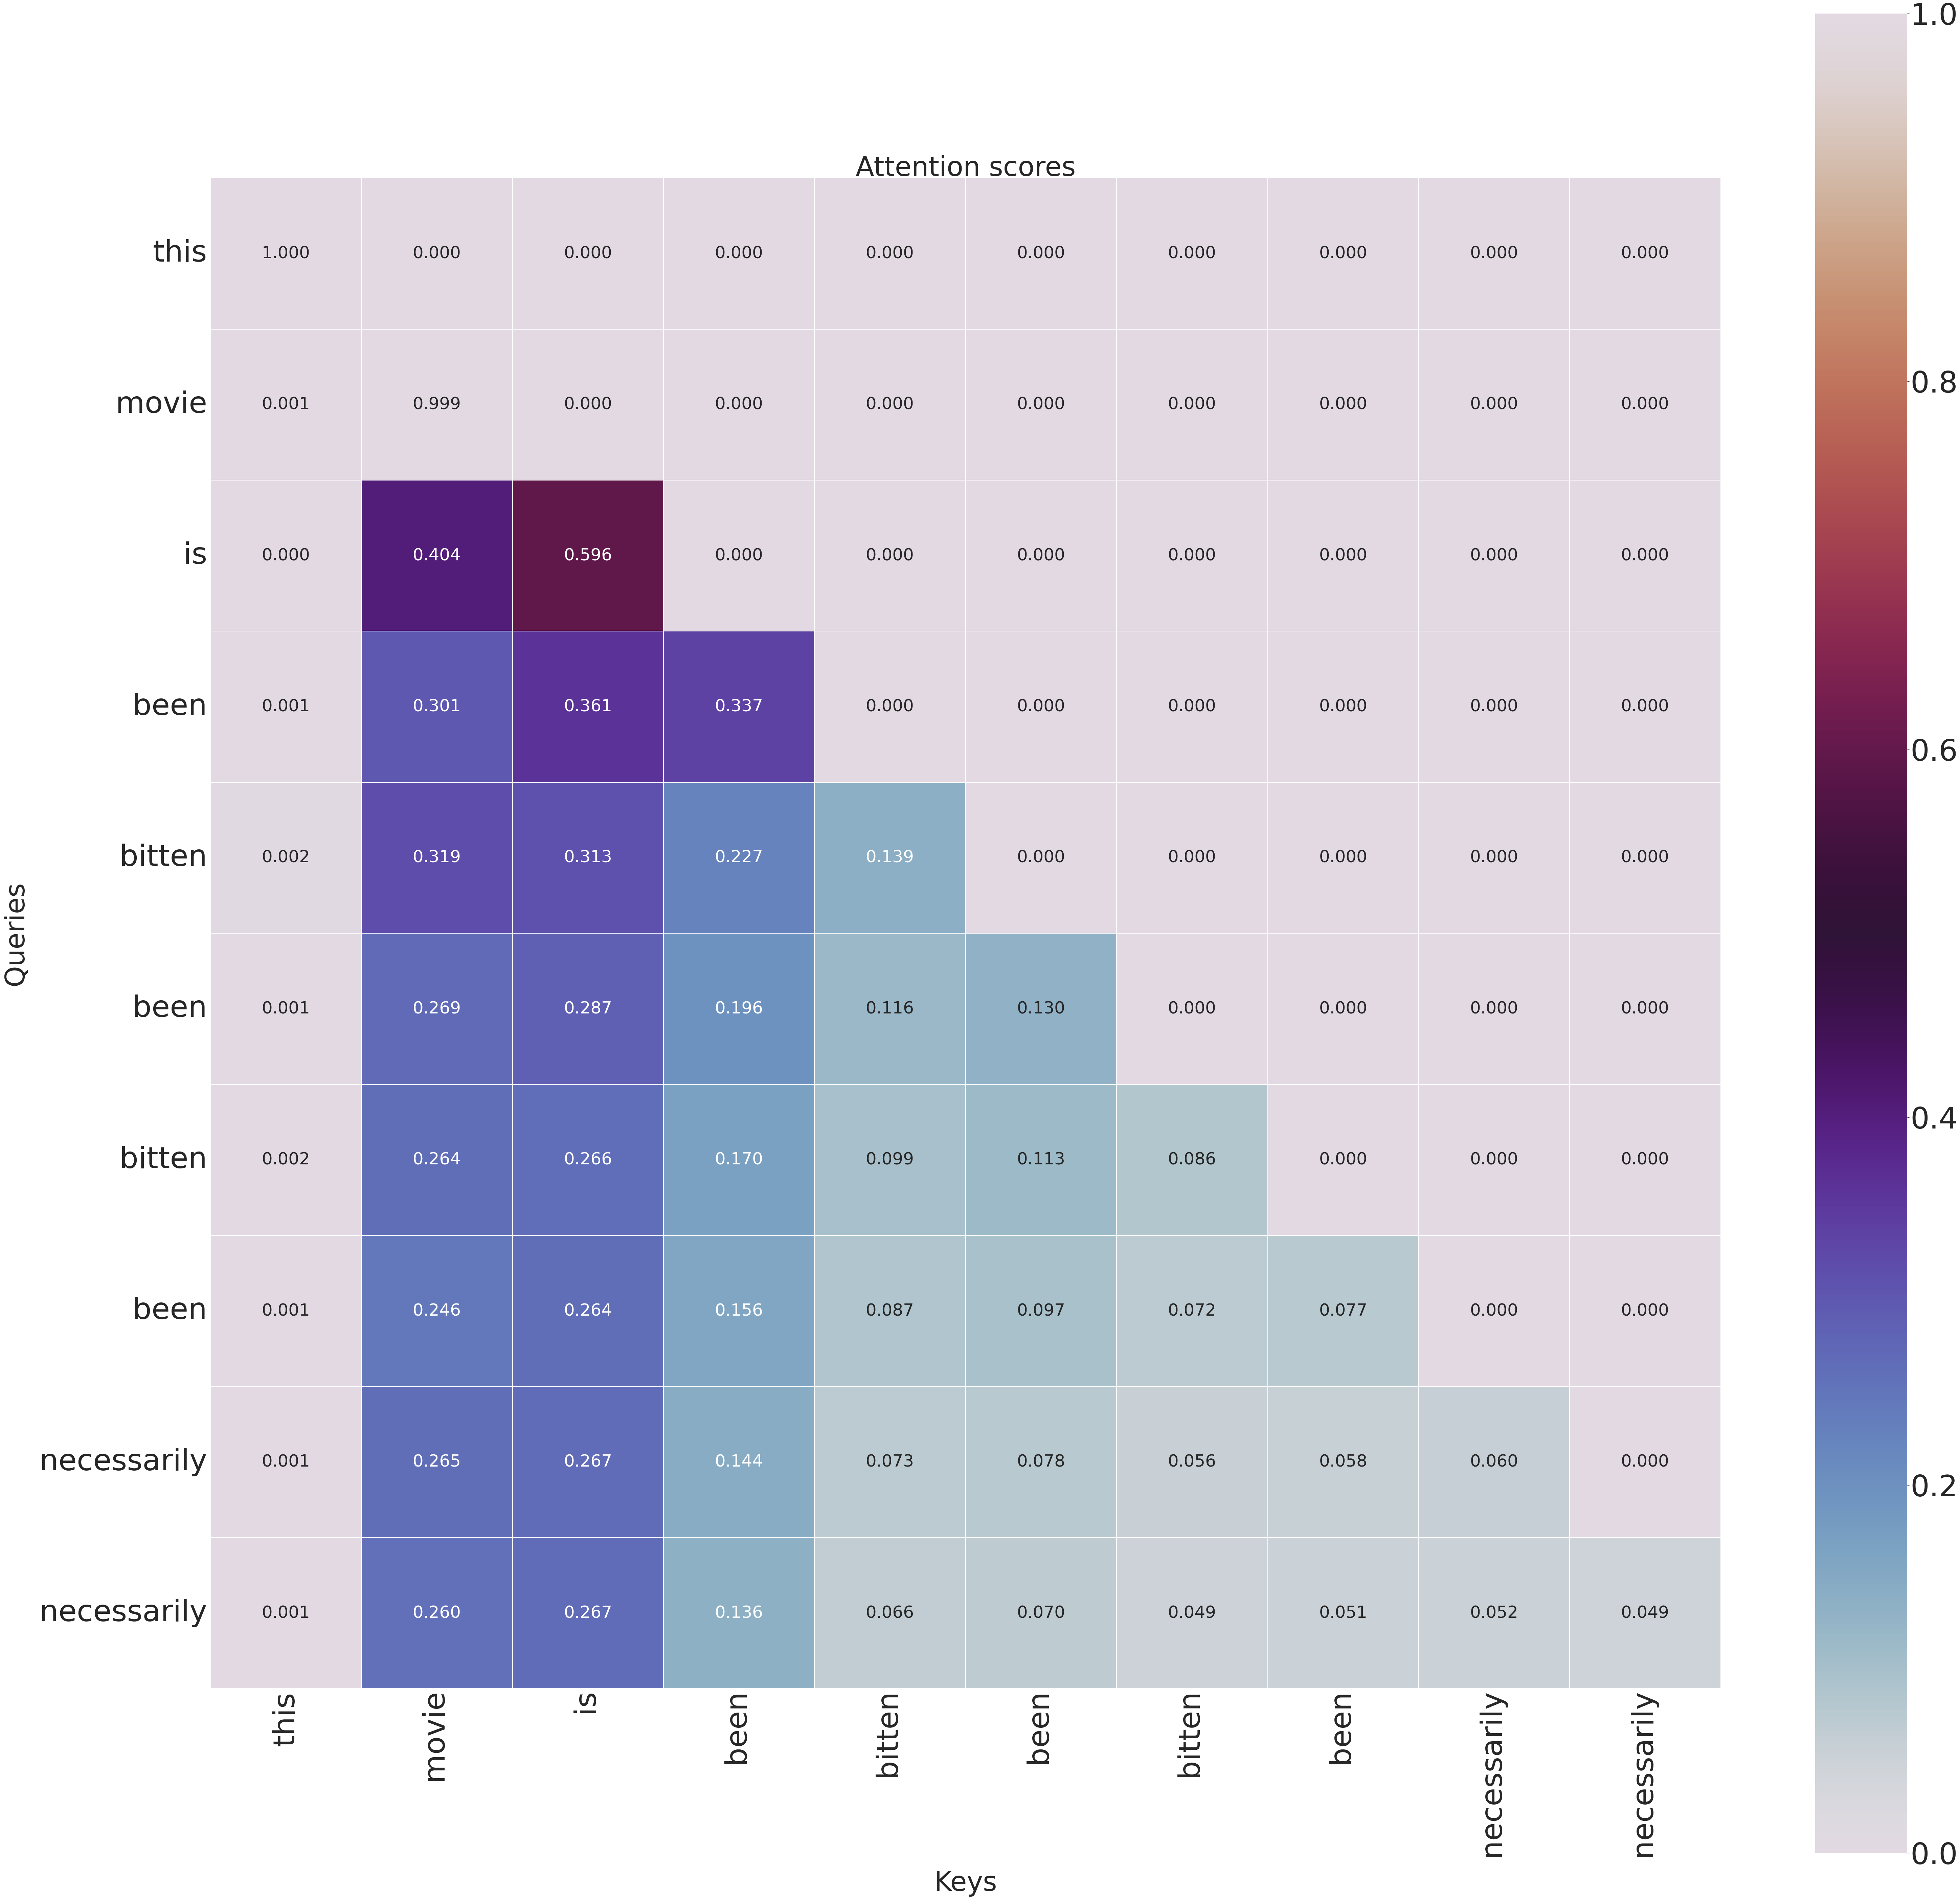

In [133]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[2][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
plt.savefig('2Layer_Head3_Layer1.jpg')

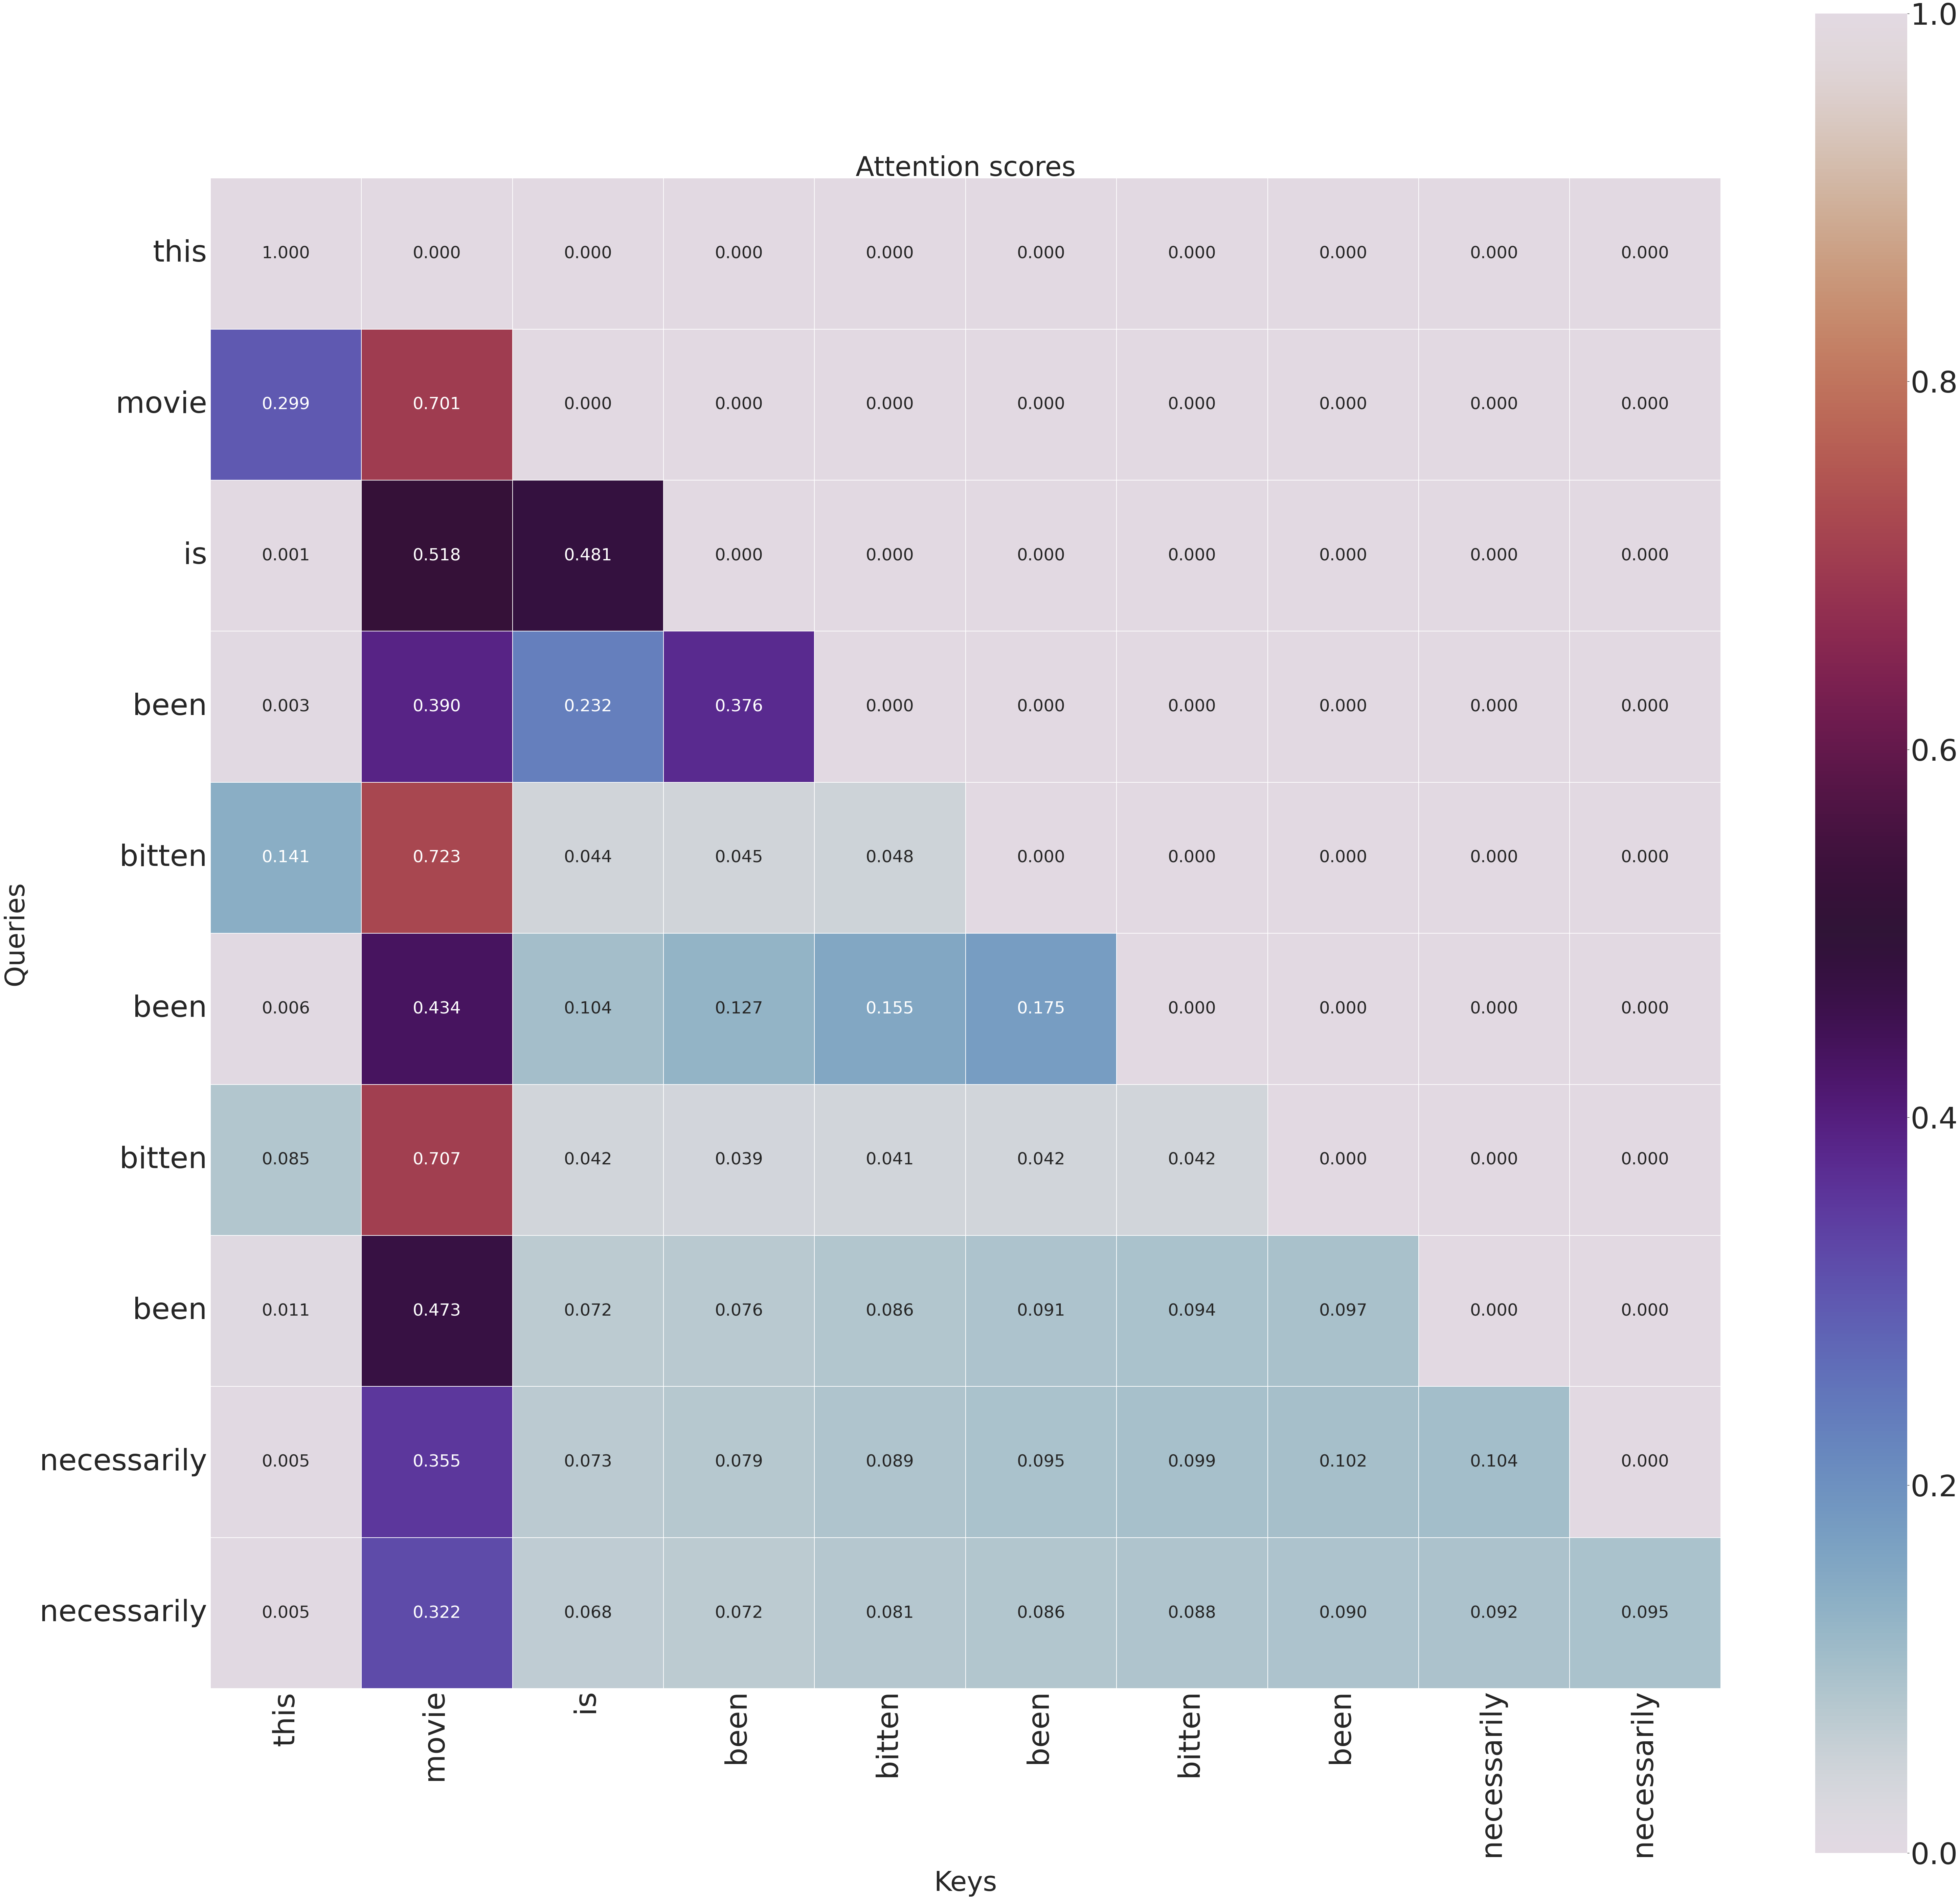

In [139]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[3][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
plt.savefig('MLPLayer_Head4_Layer2.jpg')

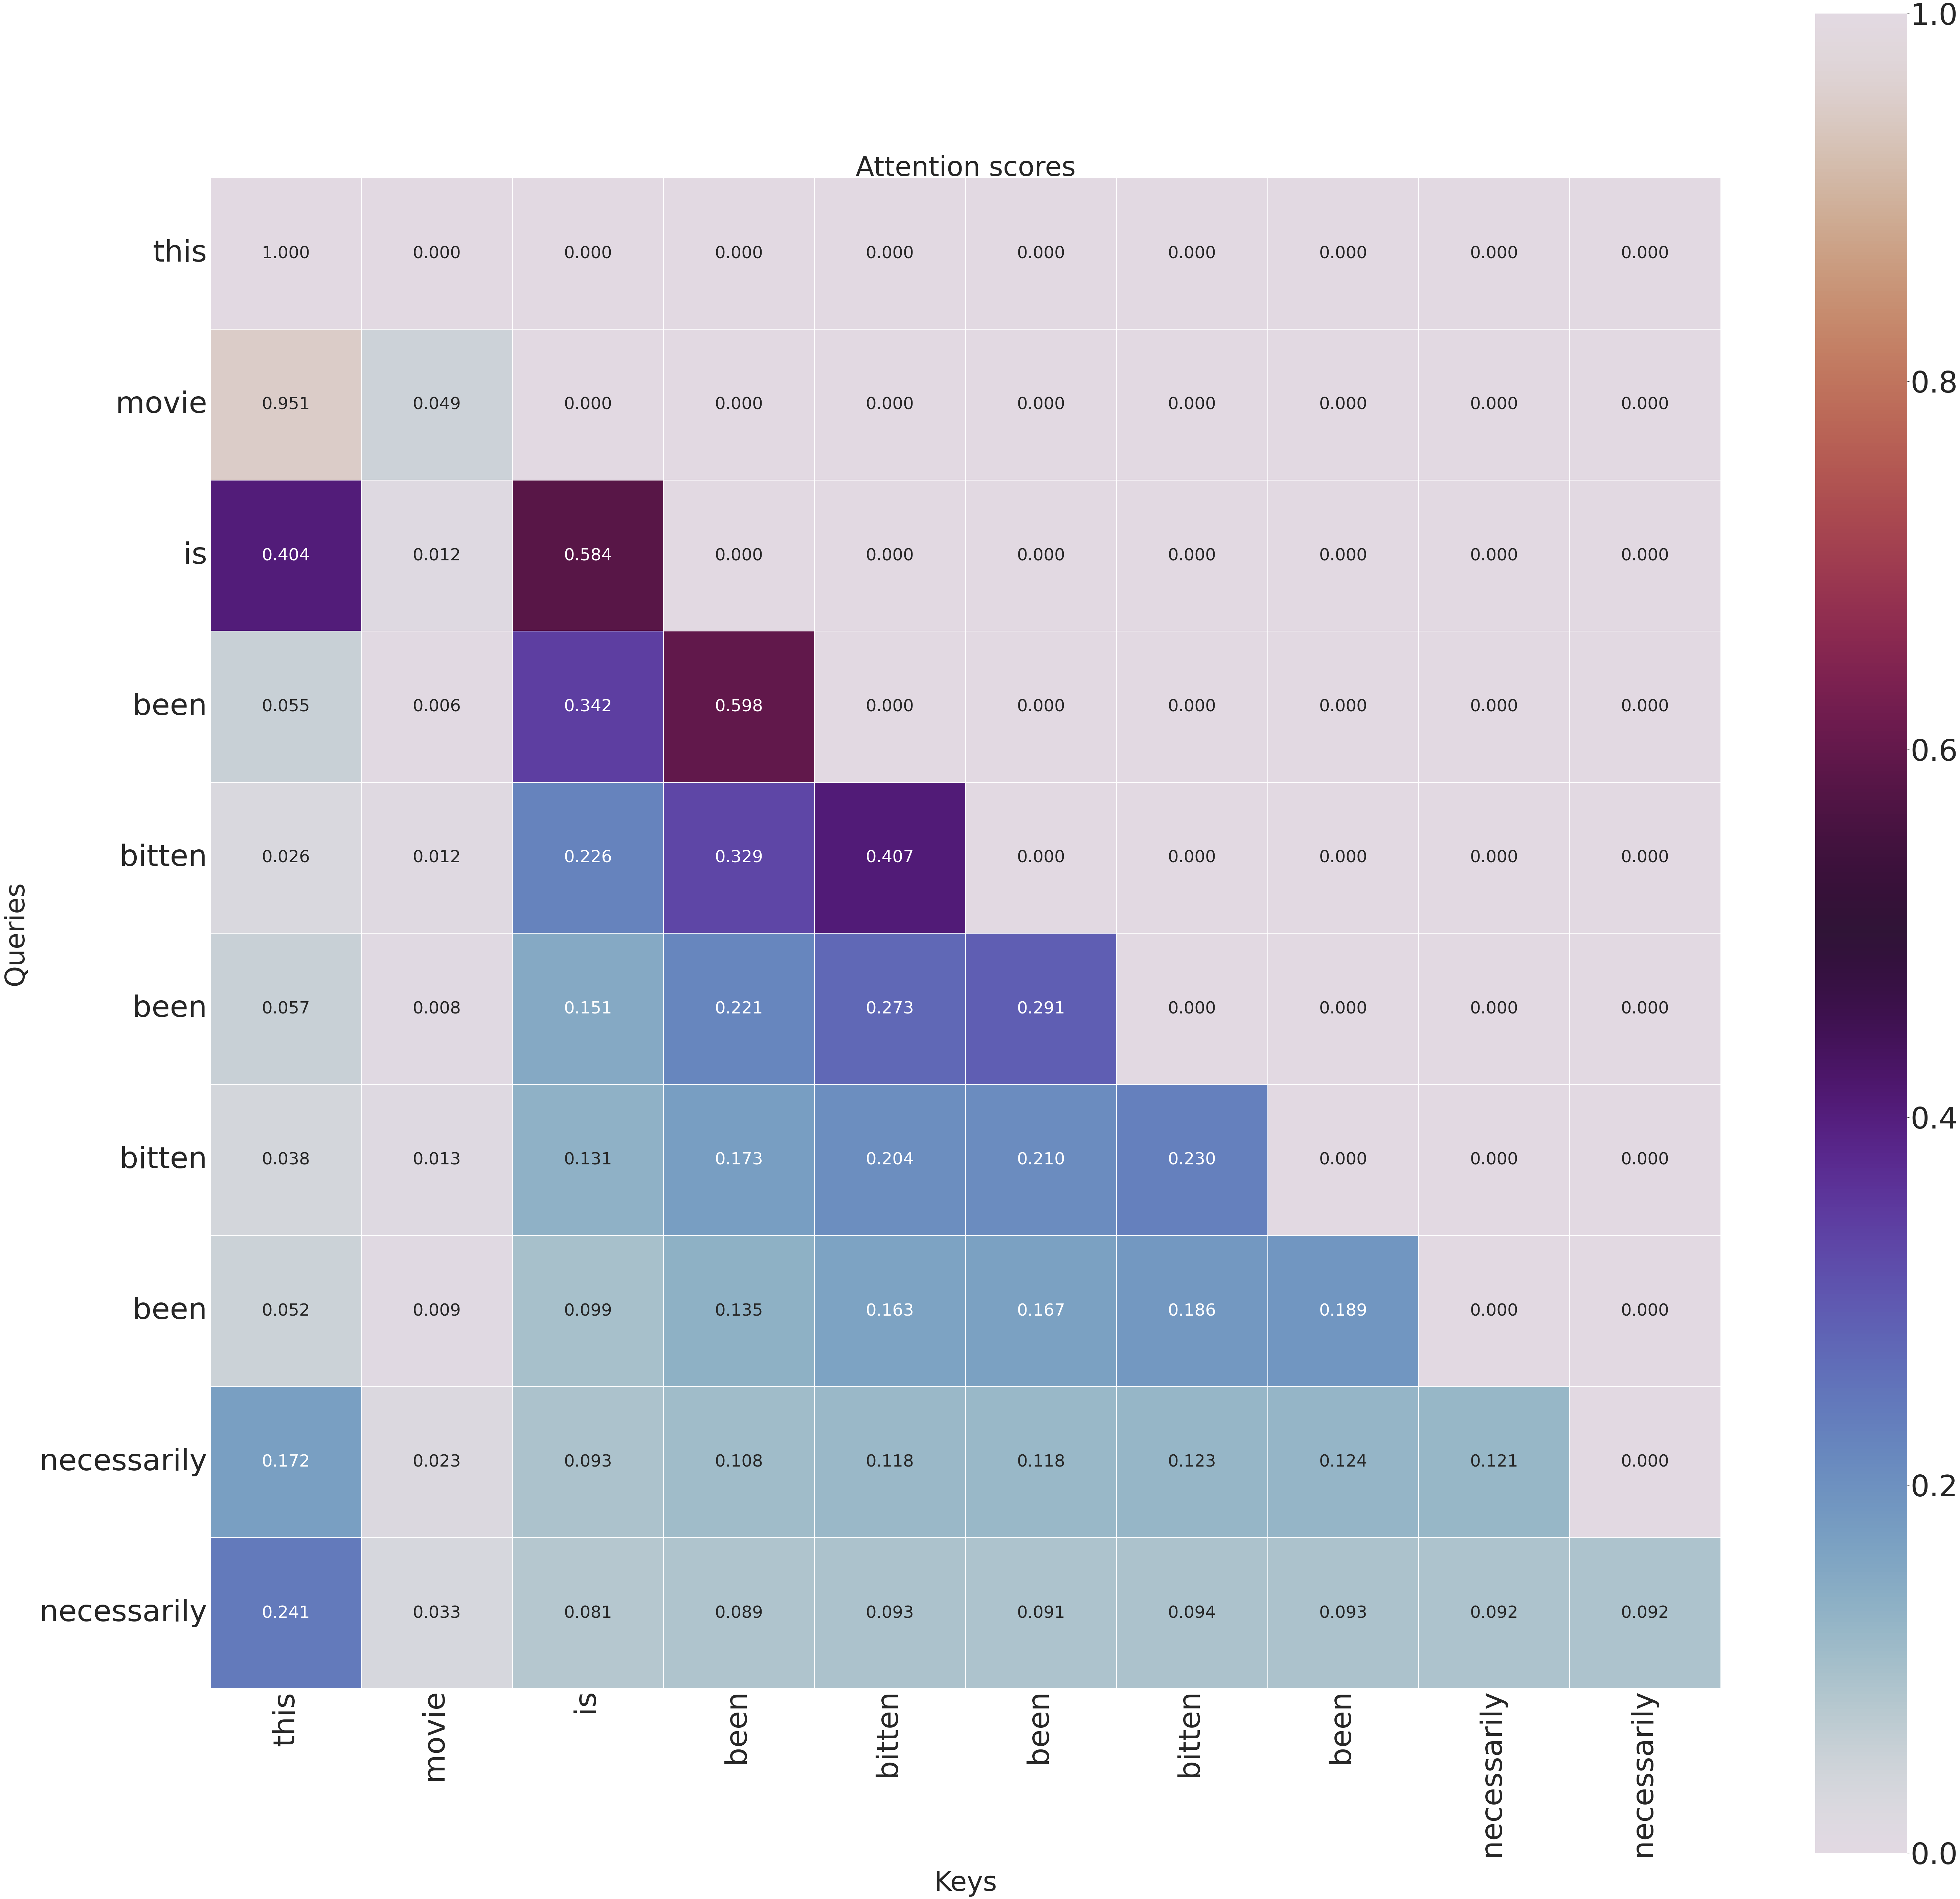

In [135]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[4][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
plt.savefig('MLPLayer_Head5_Layer1.jpg')

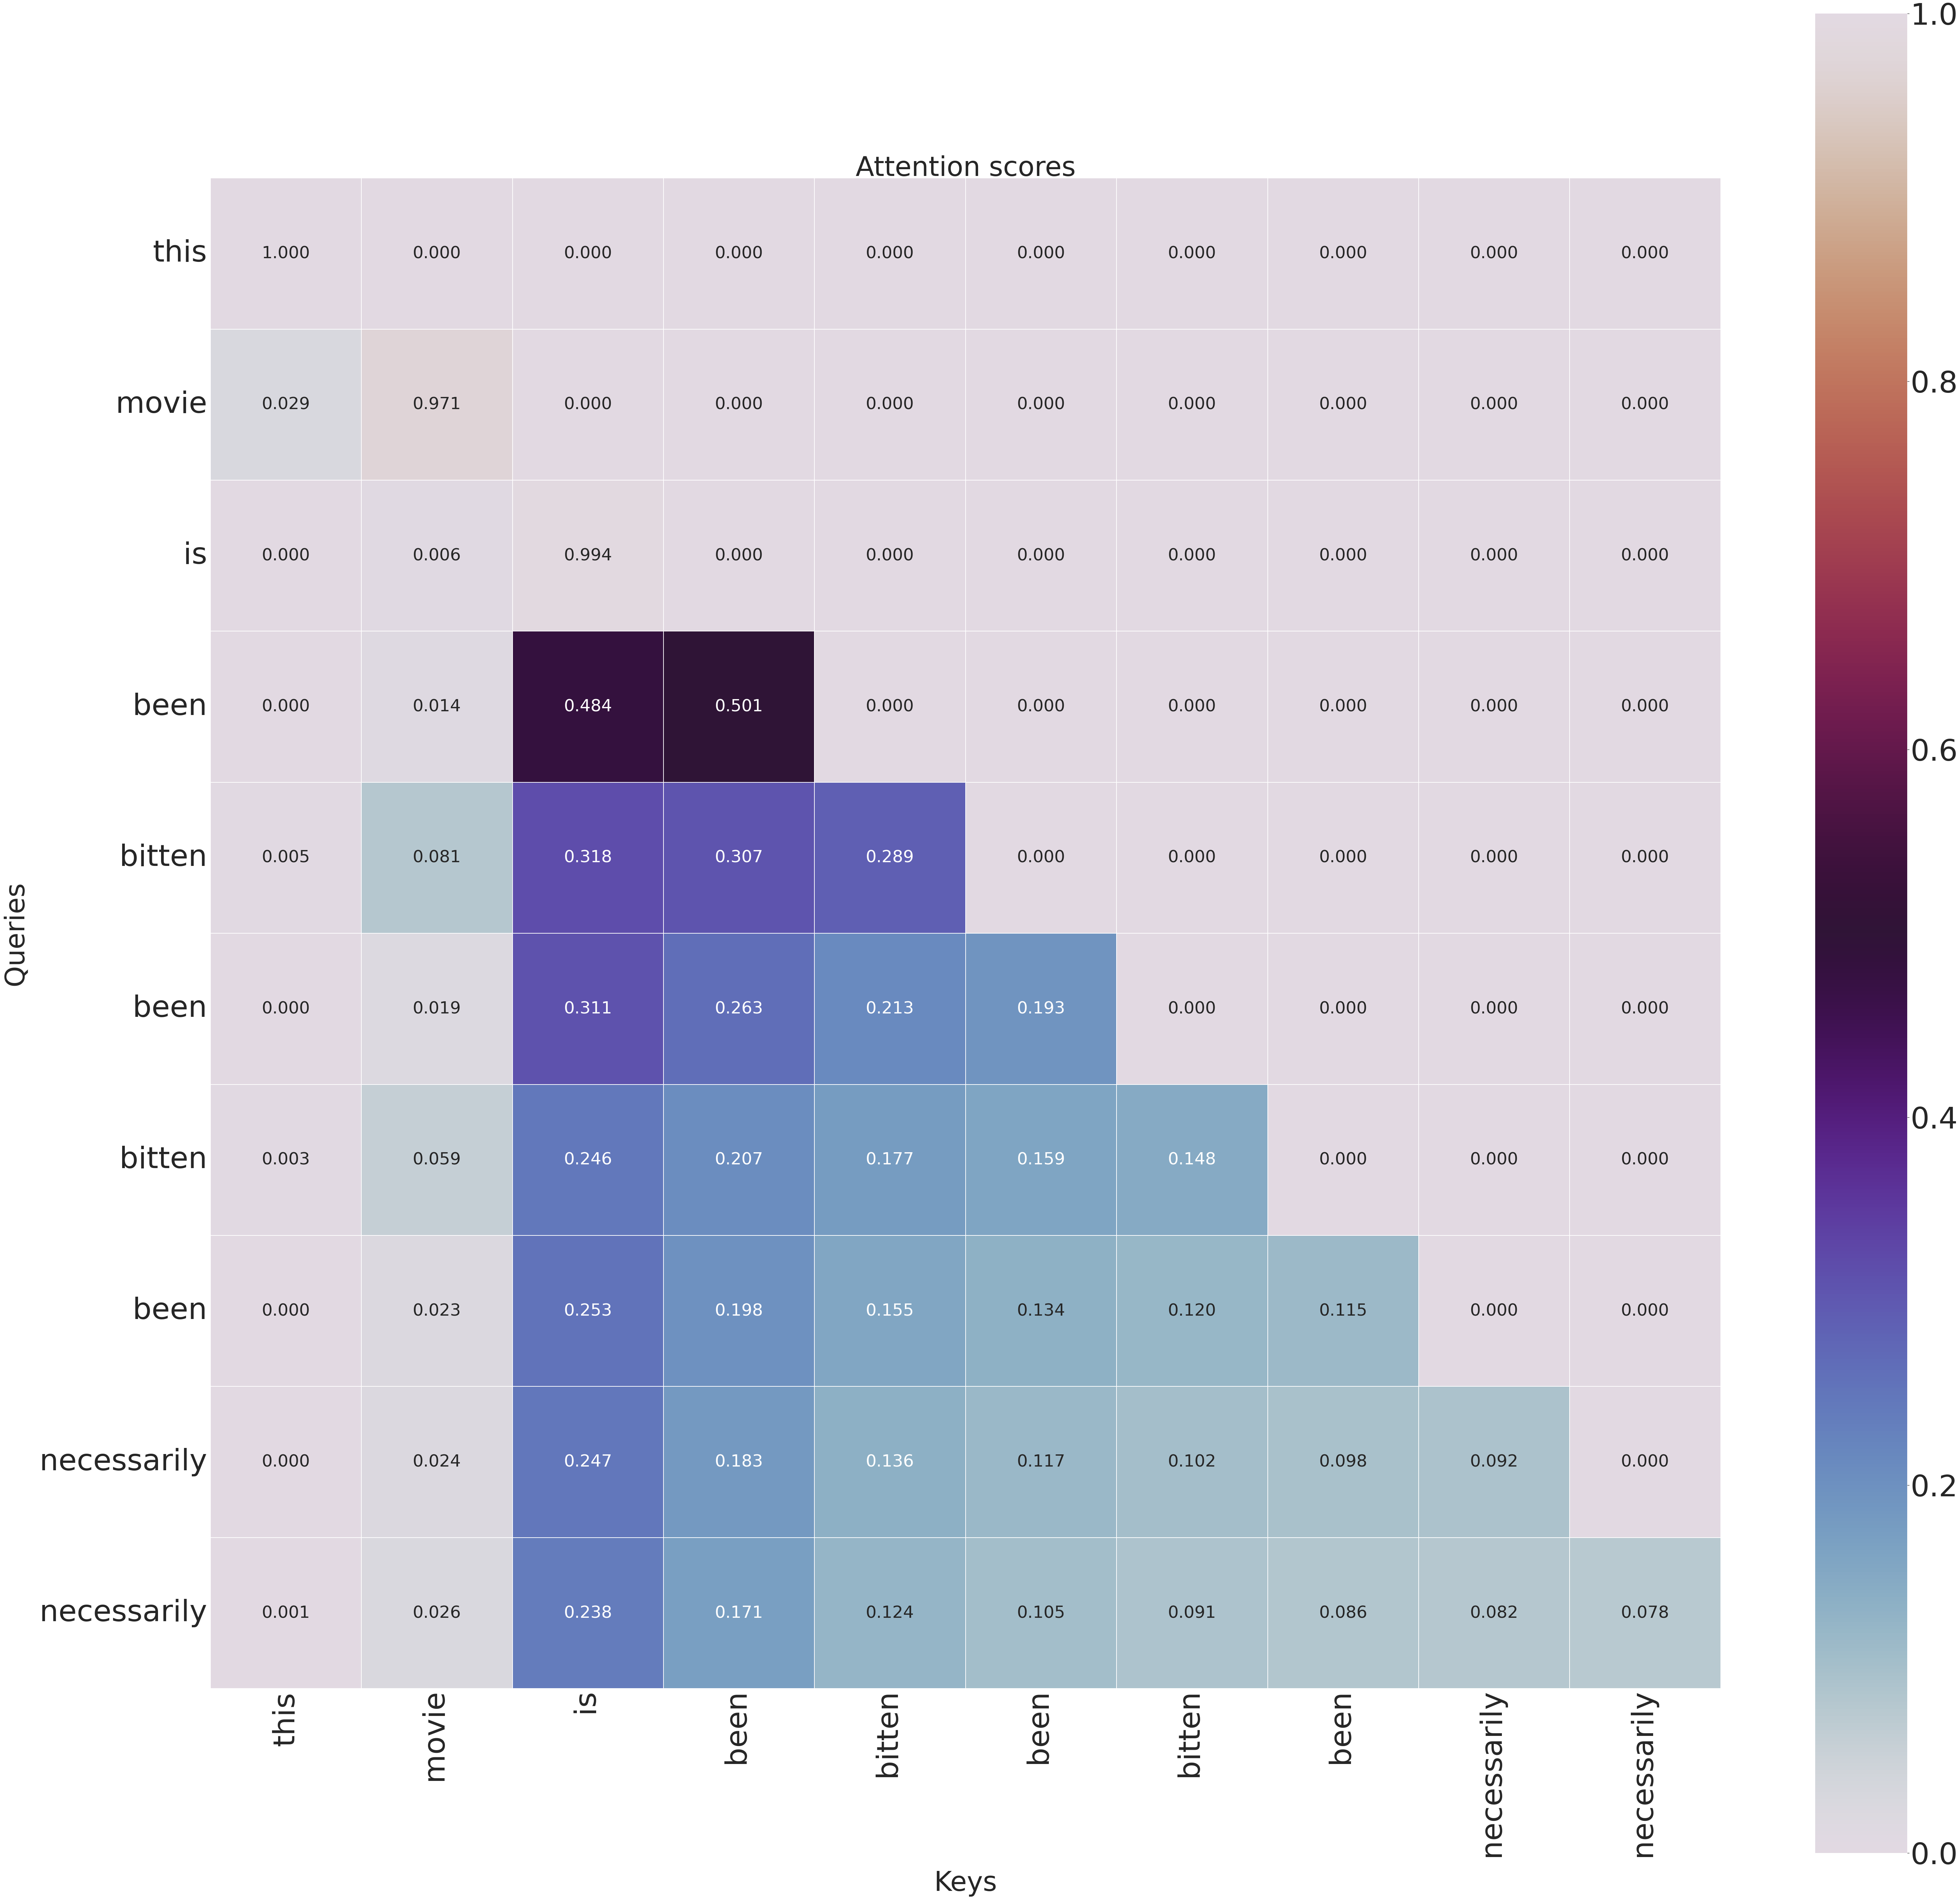

In [136]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[5][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
# plt.savefig('1Layer_Head6.jpg')

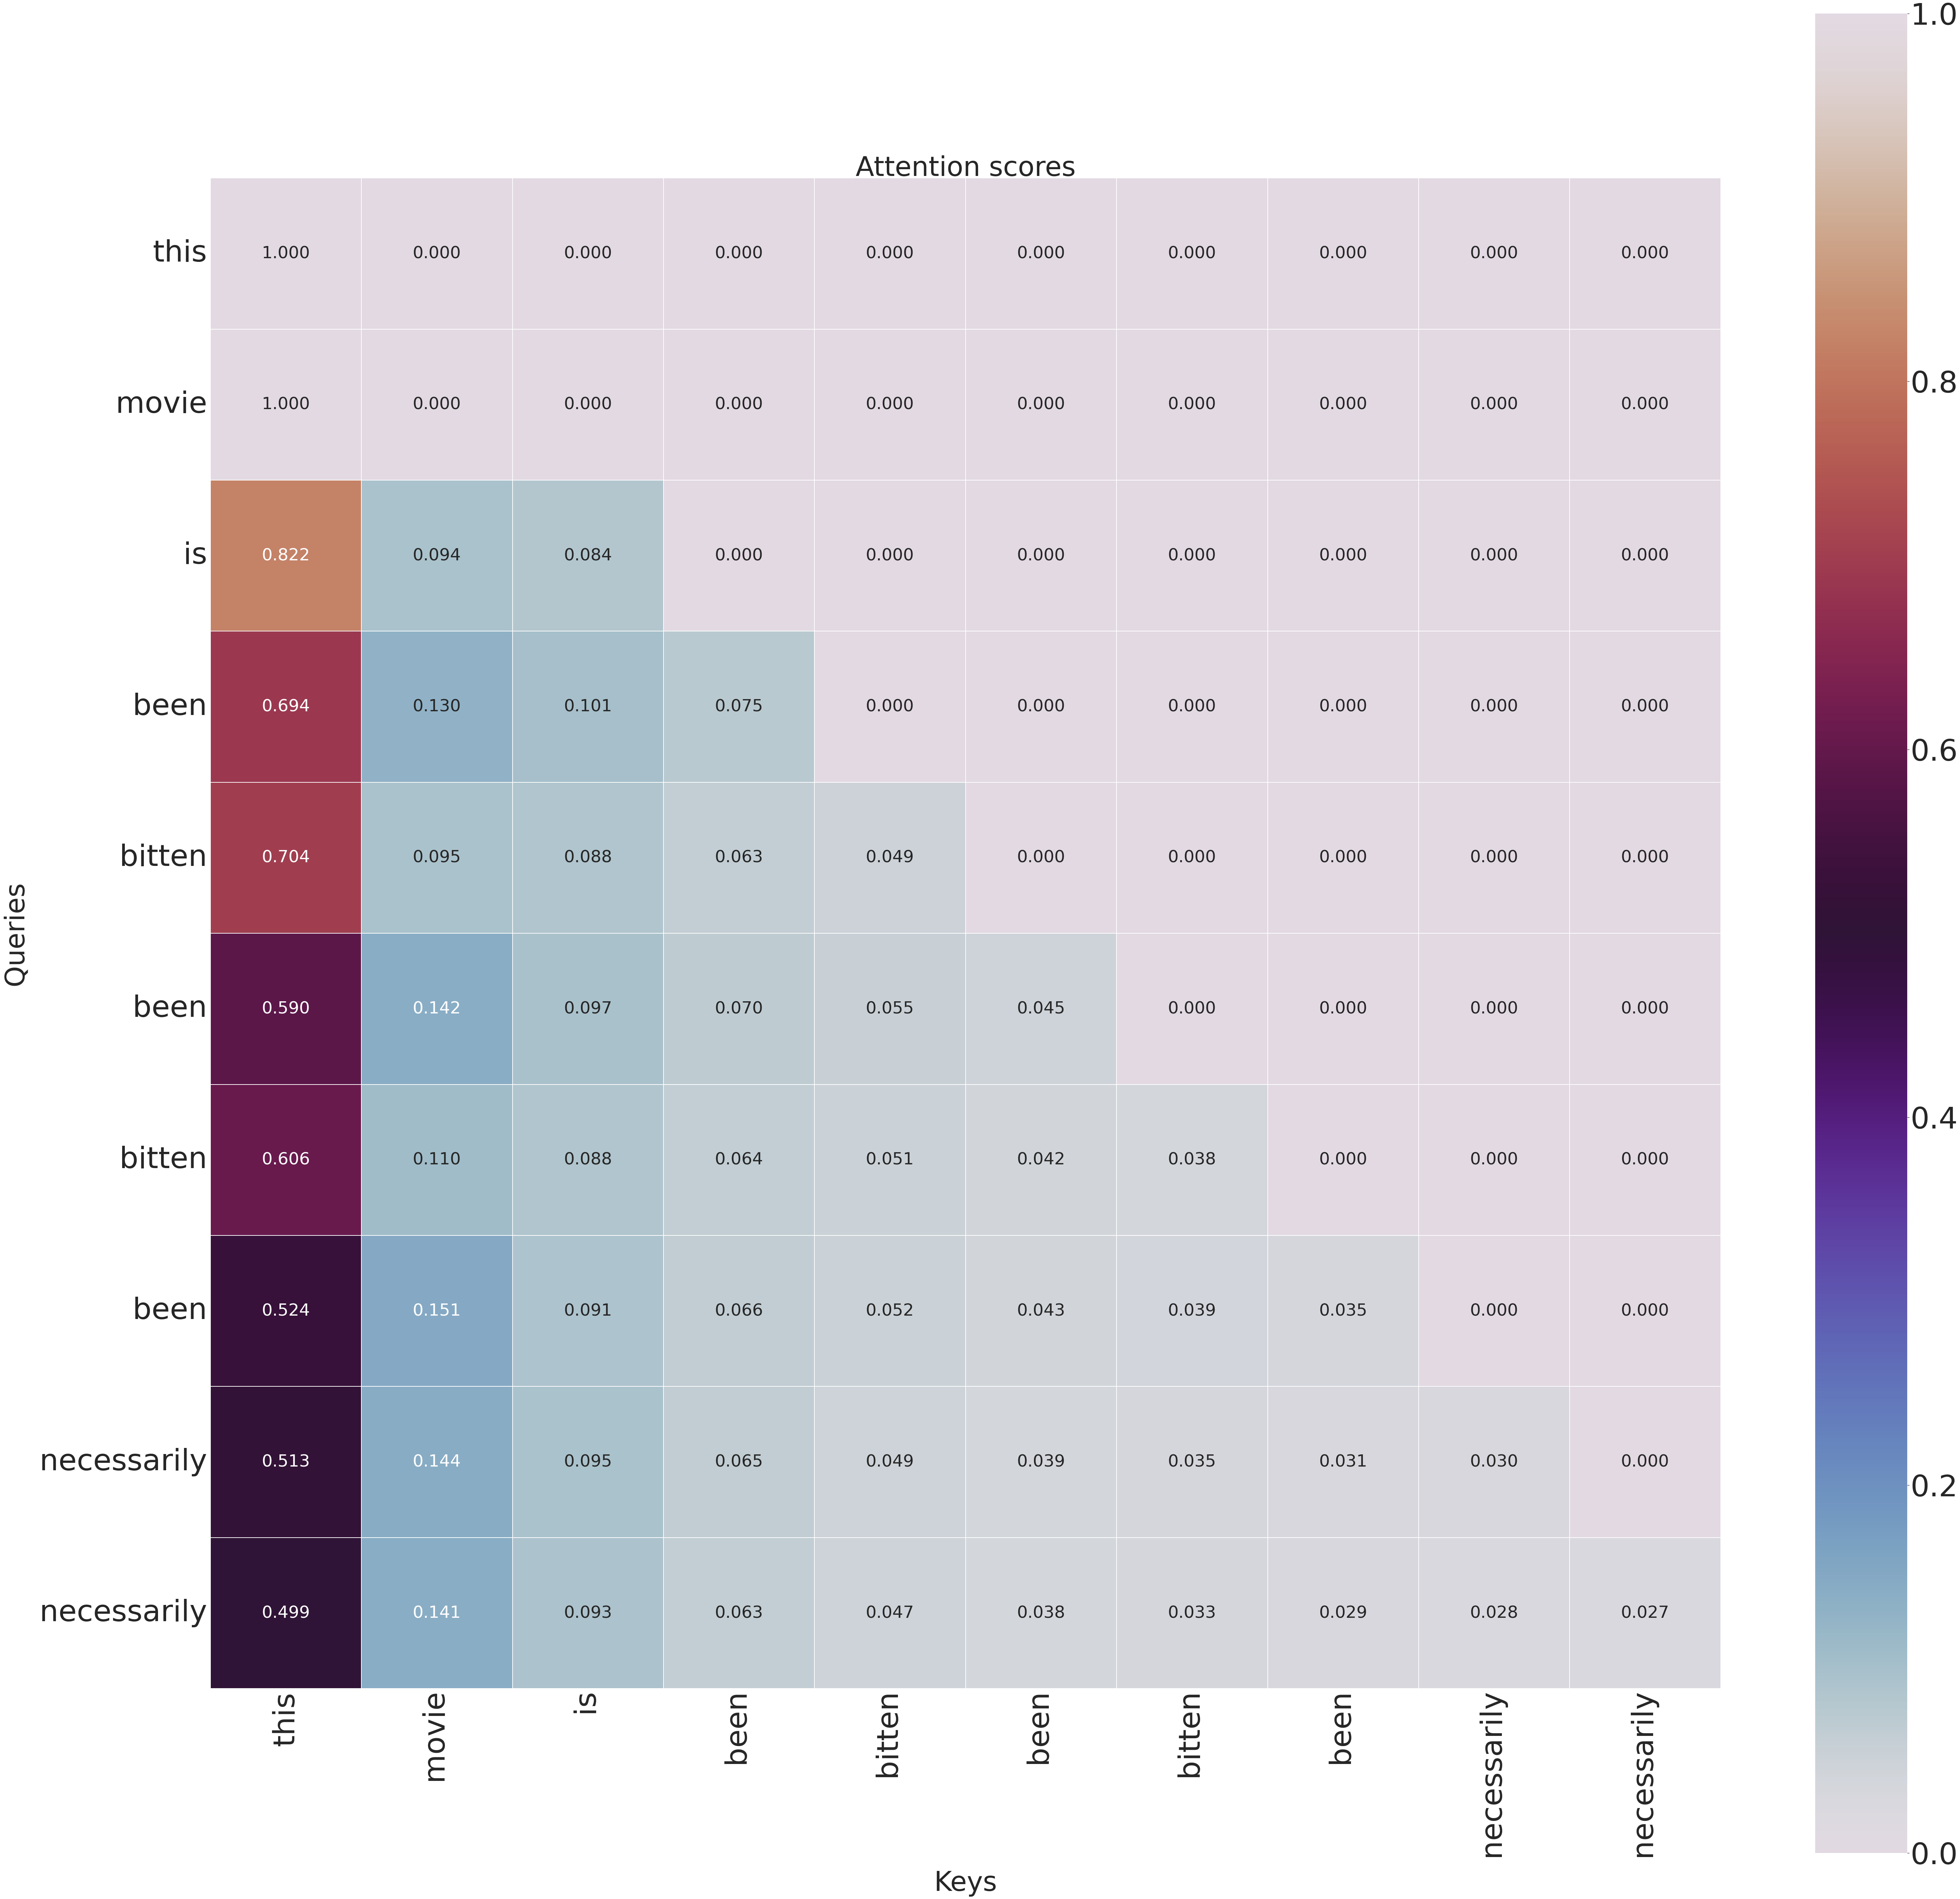

In [140]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[6][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();
plt.savefig('MLPLayer_Head7_Layer2.jpg')

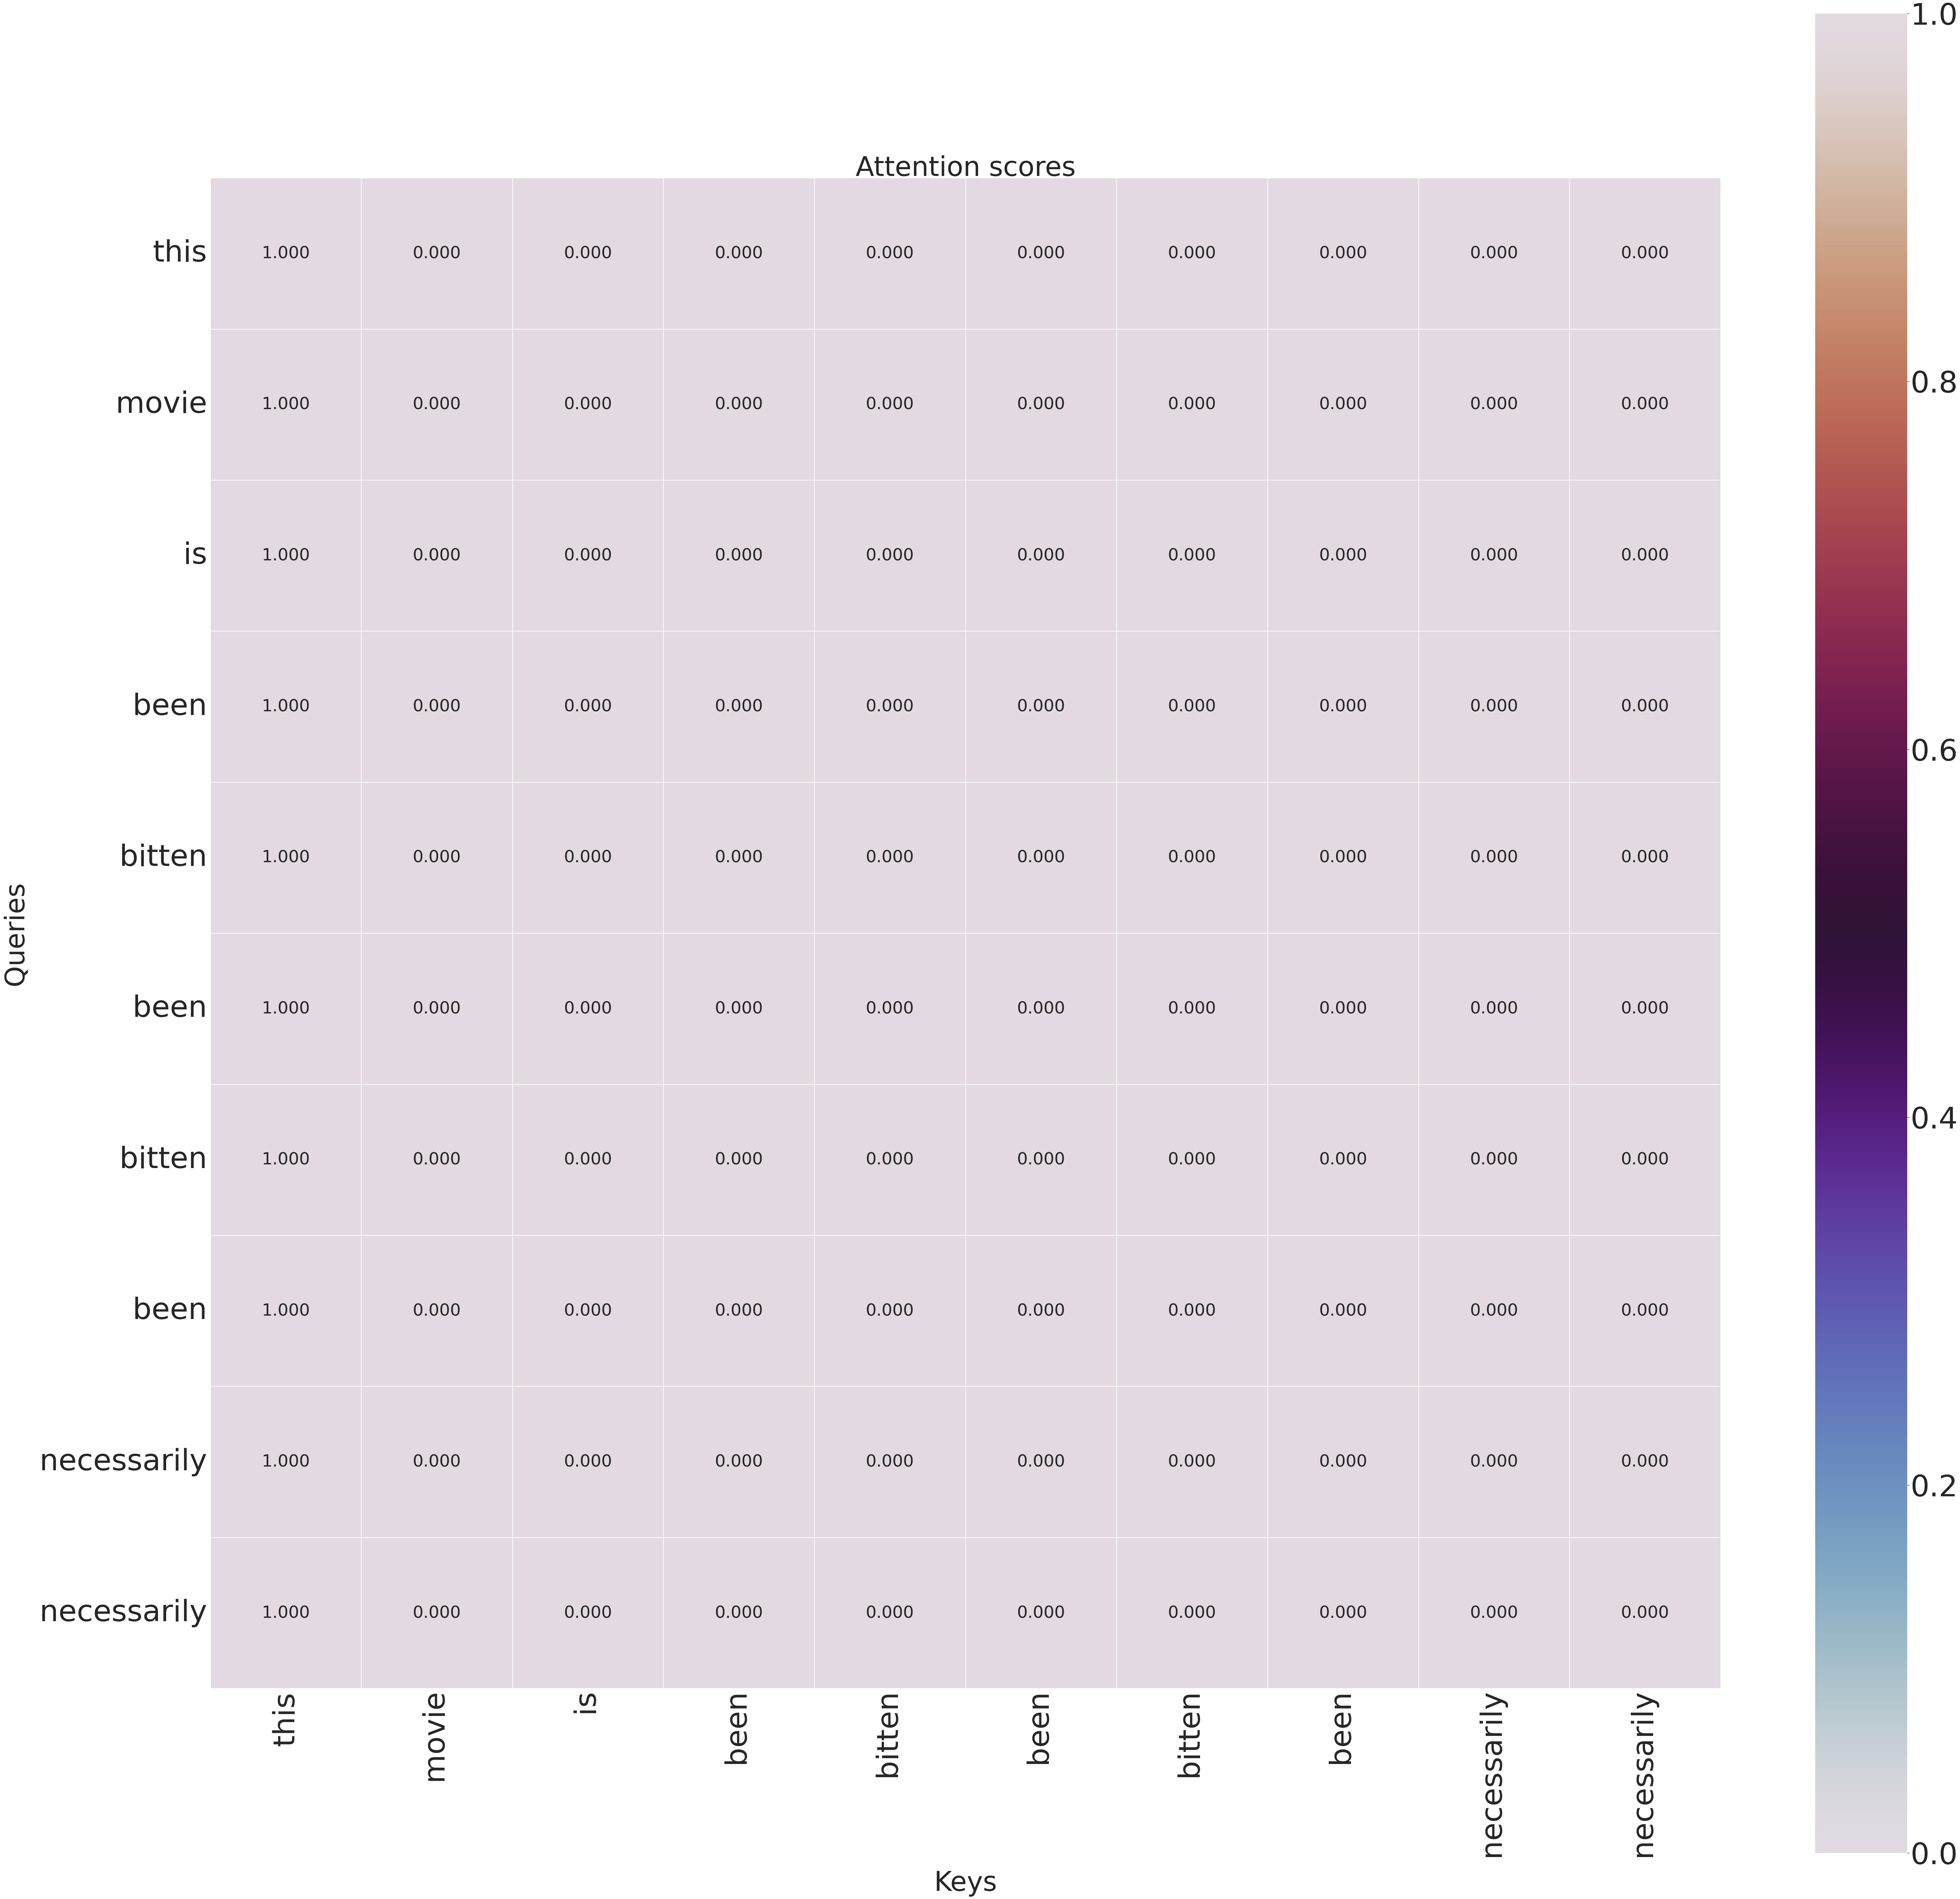

In [138]:
dfx = pd.DataFrame(keys[:-1], columns =["keys"] );
dfy2=pd.DataFrame(score[7][0:10,0:10],index=keys[:-1],columns=keys[:-1]);
plt.figure(figsize=(100.0,100.0));
plt.title("Attention scores",fontsize=80);
plt.xlabel("Keys",fontsize=50)
plt.ylabel("Queries",fontsize=50)

sns.set(font_scale=8)
s=sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight',annot_kws={"size":50});
# sns.set(font_scale=1)
s.set_xlabel('Keys', fontsize=80)
s.set_ylabel('Queries', fontsize=80)

plt.plot();